In [210]:
%load_ext autoreload
%autoreload 2
%autosave 30

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

import matplotlib.pyplot as plt
from plotutils import plot_images_as_grid

from imageprosessing import hist_match_images, enhance_motion_contrast, normalize_data
from sharedvariables import get_video_sessions
from video_session import VideoSession
from imageprosessing import SessionPreprocessor
from classificationutils import SessionClassifier
from patchextraction import SessionPatchExtractor
from patchextraction import SessionPatchExtractor as PE
from cnnlearning import CNN

from learningutils import ImageDataset
from classificationutils import create_probability_map
from plotutils import *
from cnnlearning import TrainingTracker, train
import os
import collections
import pathlib

import scipy
import skimage
from skimage.morphology import binary_dilation as bd

import numpy as np
import pandas as pd
import torch
import cv2
import copy

from tqdm.contrib import tzip

from patchextraction import extract_patches
from patchextraction import SessionPatchExtractor as PE
from imageprosessing import ImageRegistrator
from collections import OrderedDict

# change this
result_folder_name = 'uid0-sc-npp32-tp2-ps17-mt0-pr0-uv1'

# change this
classifier_params = collections.OrderedDict(        
    patch_size=17,
    
    mixed_channels=False,
    drop_confocal=False,

    n_negatives_per_positive=32,
    negative_extraction_mode=SessionPatchExtractor.CIRCLE,                             
    use_vessel_mask=True
)

## ## ## ## ##
report_images_folder = os.path.join(
    '..', '..', 'thesis-report', 'images', result_folder_name,
)
pathlib.Path(report_images_folder).mkdir(exist_ok=True, parents=False)

print()
results = TrainingTracker.from_file(os.path.join('tmp-res', result_folder_name, 'results.pkl'))
print('Training results loaded')

recorded_models_props = results.recorded_models['best_valid_balanced_accuracy']
model =  recorded_models_props['model'].eval()

print()
print('Model validation performance\n',  recorded_models_props['valid_classification_results'])
print()

video_sessions = get_video_sessions(marked=True, registered=False, validation=True)
print('loaded validation Video sessions:', len(video_sessions))
[vs.basename for vs in video_sessions]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 30 seconds

Training results loaded

Model validation performance
    Balanced Accuracy  Accuracy  Sensitivity  Specificity
0           0.819619  0.819787     0.819429     0.819809

loaded validation Video sessions: 3


['Subject10_Session109_OD_(-1,0)_1x1_416_OA790nm1_extract_reg_cropped',
 'Subject10_Session111_OS_(1.2,0)_1x1_429_OA790nm1_extract_reg_cropped',
 'Subject3_Session216_OD_(0,0)_1x1_980_OA790nm1_extract_reg_cropped']

# Performance on validation data

### Load validation videos and make sure vessel masks are ok

In [211]:
validation_video_sessions = get_video_sessions(marked=True, validation=True)

[vs.load_vessel_masks(False) for vs in validation_video_sessions]
[vs.basename for vs in validation_video_sessions]

['Subject10_Session109_OD_(-1,0)_1x1_416_OA790nm1_extract_reg_cropped',
 'Subject10_Session111_OS_(1.2,0)_1x1_429_OA790nm1_extract_reg_cropped',
 'Subject3_Session216_OD_(0,0)_1x1_980_OA790nm1_extract_reg_cropped']

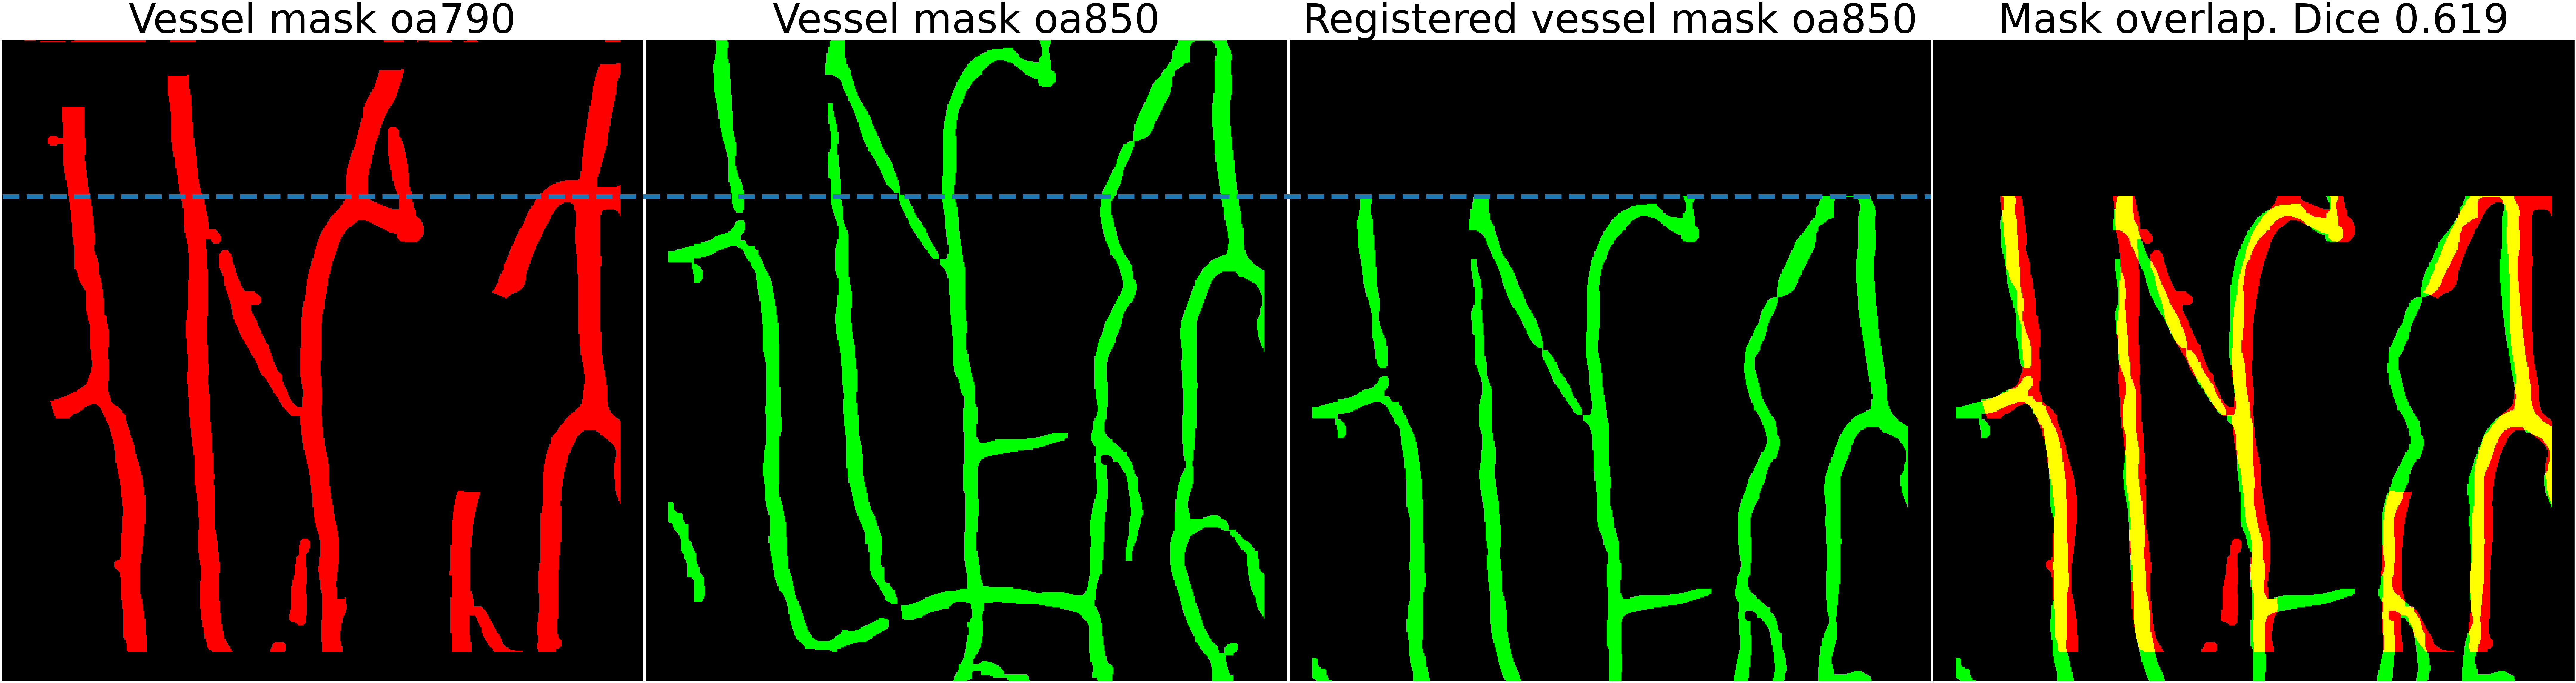

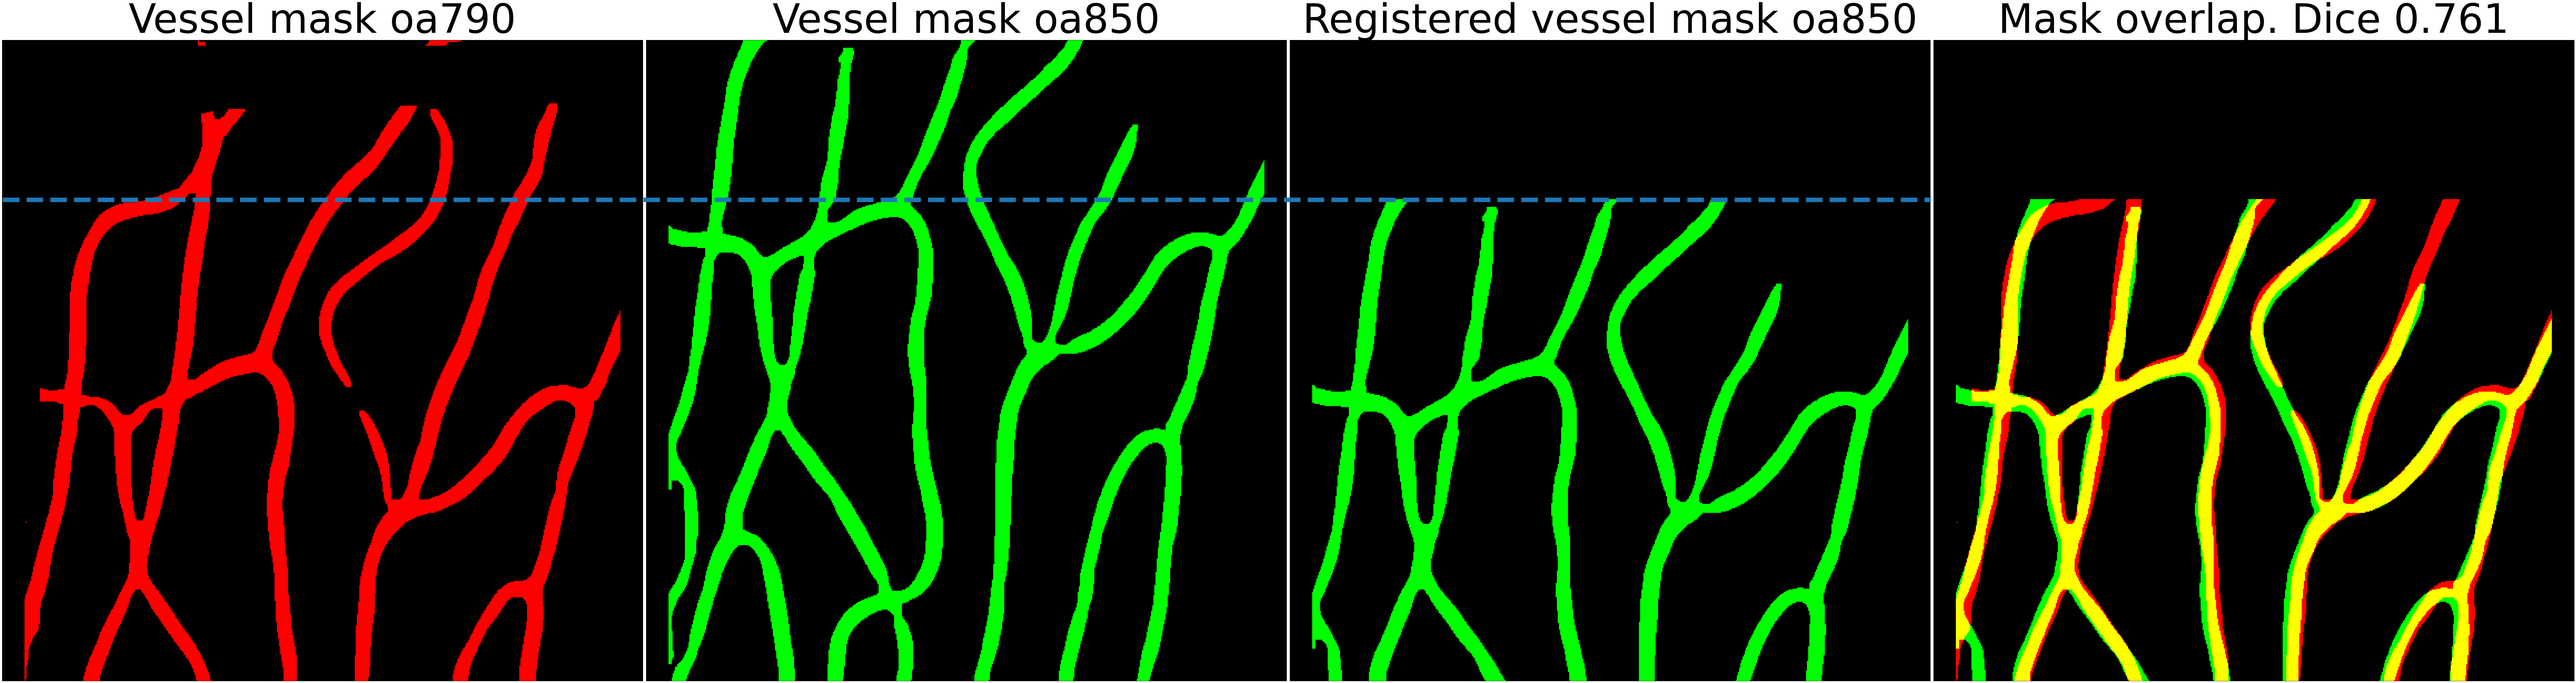

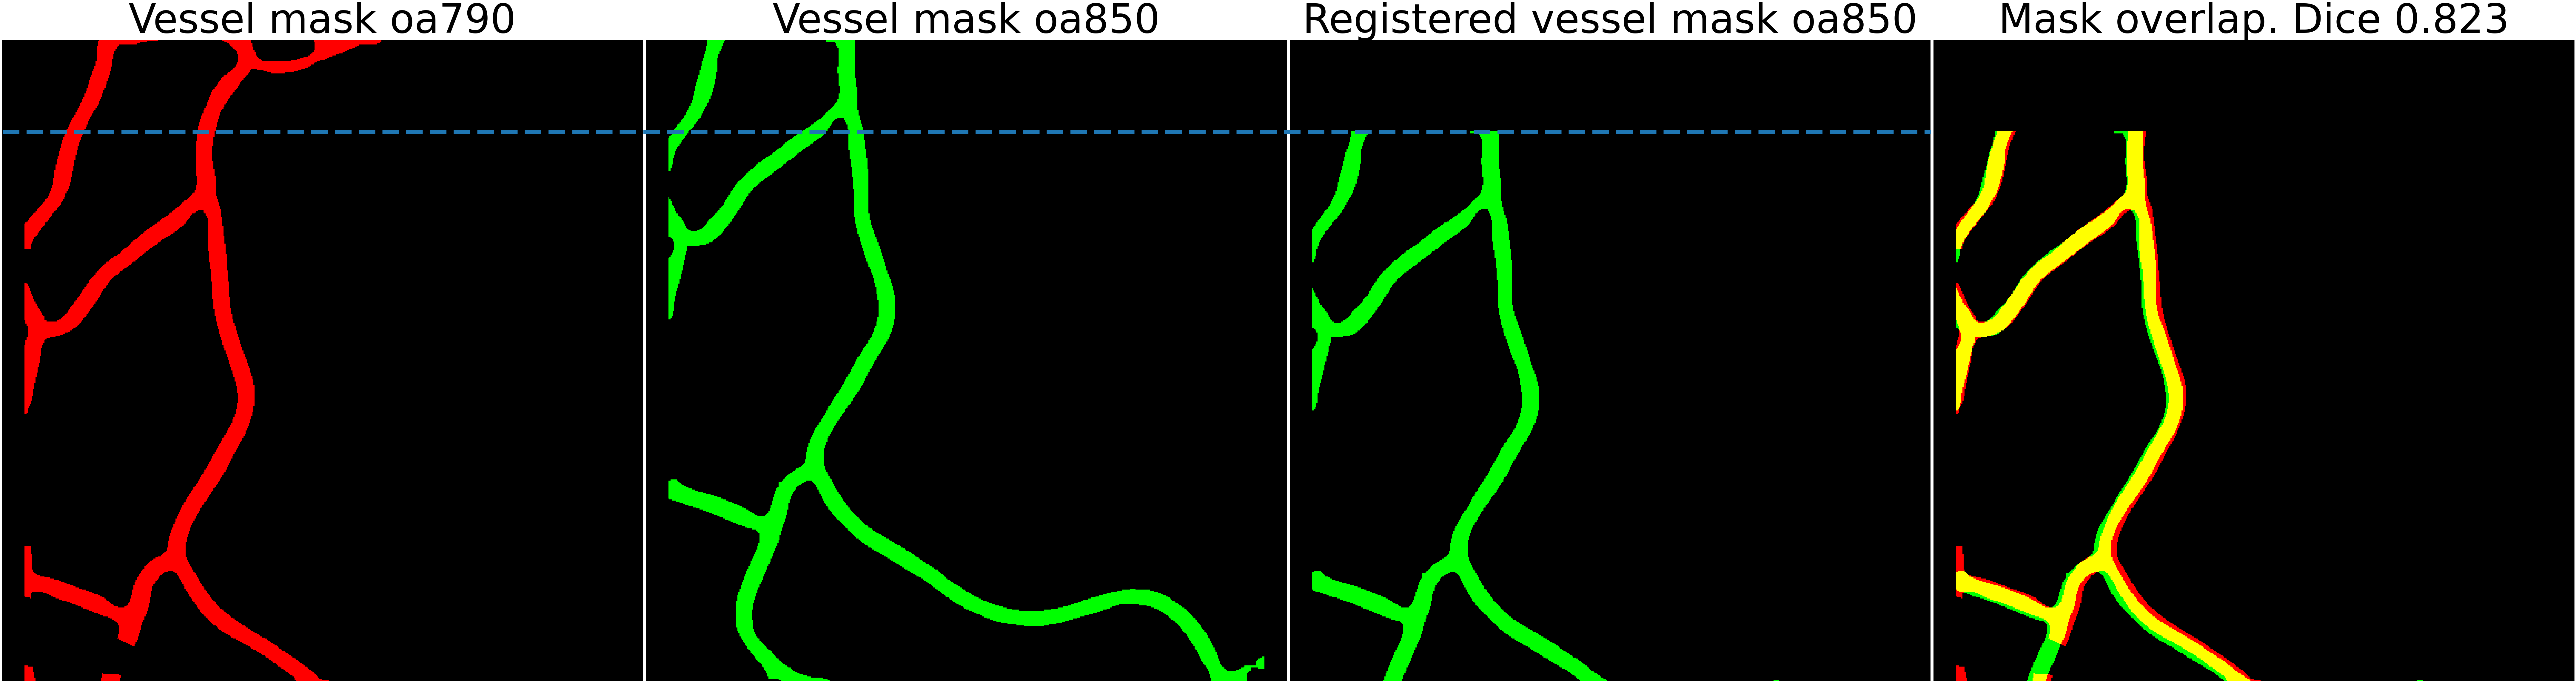

In [212]:
for vs in validation_video_sessions:
    vs.visualize_registration()

### Performance on patch classification

In [213]:
valid_recorded_model_props = results.recorded_models['best_valid_balanced_accuracy']
model = valid_recorded_model_props['model'].eval()

classification_results = valid_recorded_model_props['valid_classification_results']

sensitivities = []
specificities = []
balanced_accuracies  = []
accuracies = []

print('General validation performance\n', classification_results)
for vs in validation_video_sessions:
    vs_c = SessionClassifier(vs, model, **classifier_params)
    classification_results = vs_c.classify_cells()
    
    sensitivity = classification_results.positive_accuracy
    specificity = classification_results.negative_accuracy
    balanced_accuracy = classification_results.balanced_accuracy
    accuracy = classification_results.accuracy
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    balanced_accuracies.append(balanced_accuracy)
    accuracies.append(accuracy)
    
    print(vs.basename)
    print(f'Sensitivity: {sensitivity:.3f}', 
          f'Specificity: {specificity:.3f}',
          f'Balanced acc: {balanced_accuracy:.3f}',
          f'accuracy: {accuracy:.3f}', sep='\n')
    print('-----------')

General validation performance
    Balanced Accuracy  Accuracy  Sensitivity  Specificity
0           0.819619  0.819787     0.819429     0.819809
Subject10_Session109_OD_(-1,0)_1x1_416_OA790nm1_extract_reg_cropped
Sensitivity: 0.773
Specificity: 0.787
Balanced acc: 0.780
accuracy: 0.786
-----------
Subject10_Session111_OS_(1.2,0)_1x1_429_OA790nm1_extract_reg_cropped
Sensitivity: 0.647
Specificity: 0.848
Balanced acc: 0.748
accuracy: 0.830
-----------
Subject3_Session216_OD_(0,0)_1x1_980_OA790nm1_extract_reg_cropped
Sensitivity: 0.881
Specificity: 0.836
Balanced acc: 0.858
accuracy: 0.838
-----------


In [214]:
test_sensitivity = np.mean(sensitivities)
test_specificity = np.mean(specificities)
test_balanced_accuracy = np.mean(balanced_accuracies)
test_accuracy = np.mean(accuracies)

performance_data = {
    'Balanced accuracy': test_balanced_accuracy,
    'Accuracy': test_accuracy,
    'Sensitivity': test_sensitivity,
    'Specificity': test_specificity
}

df = pd.DataFrame(performance_data, columns=list(performance_data.keys()), index=[0])
print(df.to_string(index=False))


 Balanced accuracy  Accuracy  Sensitivity  Specificity
          0.795338   0.81815      0.76706     0.823617


### Position estimation

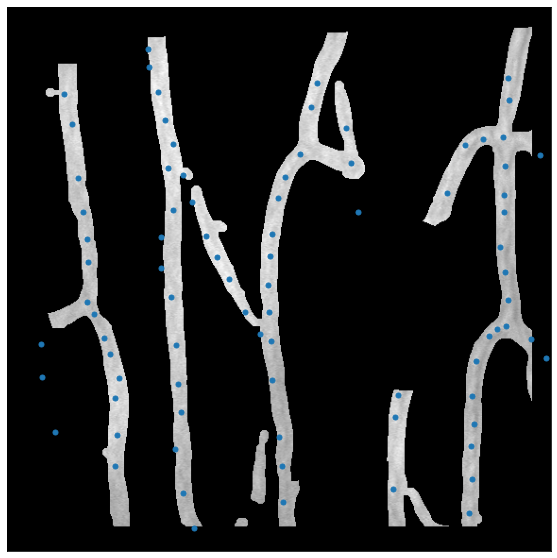

In [102]:
vs = video_sessions[0]
frame_idx = list(vs.cell_positions.keys())[-1]

positions = vs.cell_positions[frame_idx]
masked_frame = vs.frames_oa790[frame_idx] * vs.vessel_mask_oa790 * vs.mask_frames_oa790[frame_idx]

### plots #### 
plt.rcParams['image.cmap'] = 'gray'
plt.figure(figsize=(10, 10))
no_ticks()
plt.imshow(masked_frame)
plt.scatter(positions[:, 0], positions[:, 1], s=25)
pass

In [193]:
# from guitools import CvRoipolySelector
# vessel_mask_clone = np.uint8(vs.vessel_mask_oa790.copy() * 255)
# vessel_mask_clone = vessel_mask_clone[..., np.newaxis]
# vessel_mask_clone = np.concatenate((vessel_mask_clone, vessel_mask_clone, vessel_mask_clone), axis=-1)

# # for positions in vs.cell_positions.values():
# for (x, y) in positions:
#     vessel_mask_clone = cv2.circle(vessel_mask_clone, (x, y), 5, (255, 0, 0), -1)

# polyselector = CvRoipolySelector('Select part to remove', vessel_mask_clone)
# polyselector.activate()
# plt.figure(figsize=(25, 10))
# no_ticks()
# plt.imshow(vessel_mask_clone[..., -1] * ~polyselector.mask)

# vs.vessel_mask_oa790[polyselector.mask] = 0
# plt.figure(figsize=(25, 10))
# no_ticks()
# plt.imshow(vs.vessel_mask_oa790)

In [106]:
vs_c = SessionClassifier(vs, model, **classifier_params)
estimated_locations = vs_c.estimate_locations(frame_idx, grid_search=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [02:32<00:00,  8.50s/it]


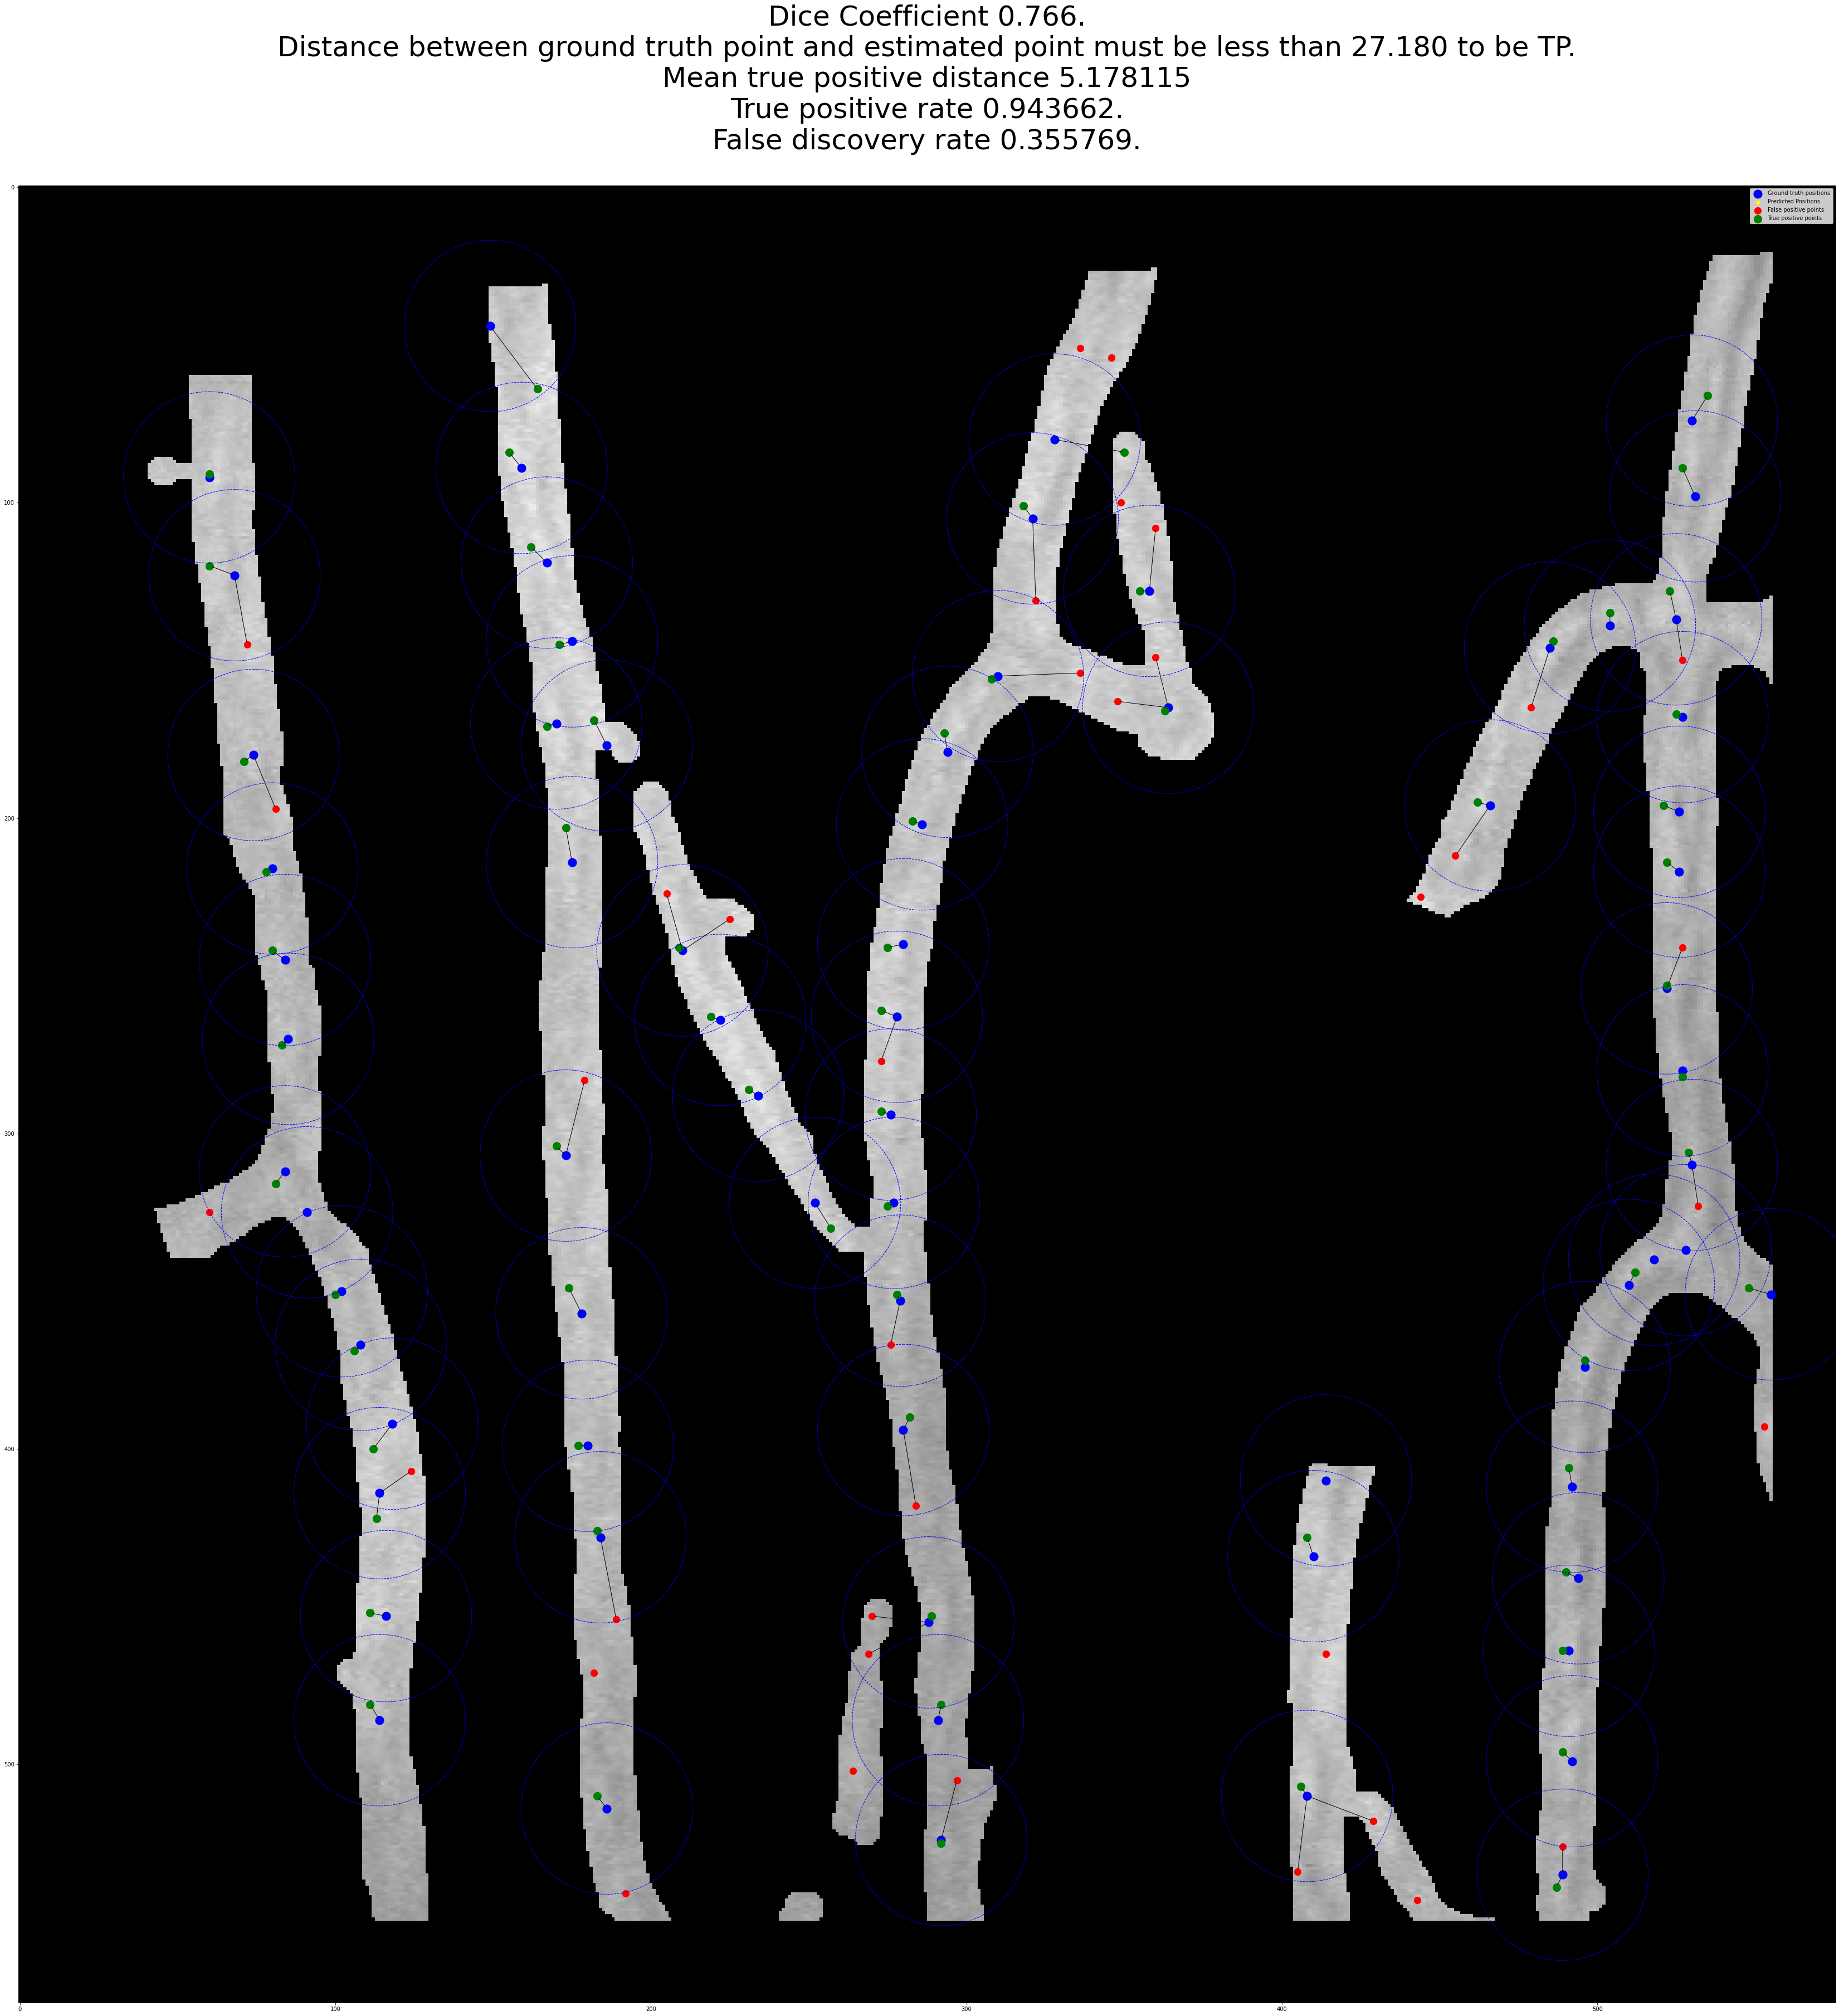

In [109]:
plt.rcParams['axes.titlesize'] = 50
vs_c.result_evaluations[frame_idx].visualize()

In [132]:

vs_c.save(os.path.join(result_evaluation_folder, f'uid{vs.uid}_classification_results.pkl'), v=True)

Saved tmp-res/uid0-sc-npp32-tp2-ps17-mt0-pr0-uv1/evaluation\uid416_classification_results.pkl


In [111]:
vs_c = SessionClassifier(vs, model, **classifier_params)

for frame_idx in vs.cell_positions:
    estimated_locations = vs_c.estimate_locations(frame_idx, grid_search=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [02:30<00:00,  8.36s/it]


In [135]:
dices = [evaluation.dice for evaluation in vs_c.result_evaluations.values()]
false_discovery_rates = [evaluation.false_discovery_rate for evaluation in vs_c.result_evaluations.values()]
true_positive_rates = [evaluation.true_positive_rate for evaluation in vs_c.result_evaluations.values()]

mean_dice = np.mean(dices)
mean_false_discovery_rates = np.mean(false_discovery_rates)
mean_true_positive_rates = np.mean(true_positive_rates)

mean_dice, mean_false_discovery_rates, mean_true_positive_rates

(0.7239890873257062, 0.35502033065001903, 0.8332666374660417)

In [136]:
sigmas = [evaluation.sigma for evaluation in vs_c.result_evaluations.values()]
hs = [evaluation.extended_maxima_h for evaluation in vs_c.result_evaluations.values()]
ts = [evaluation.region_max_threshold for evaluation in vs_c.result_evaluations.values()]

mean_sigma = np.mean(sigmas)
mean_h = np.mean(hs)
mean_t = np.mean(ts)

mean_sigma, mean_h, mean_t

(1.833333333333334, 0.3833333333333333, 0.6166666666666668)

In [215]:
uid_to_s = {416: 1.833333333333334, 429: 1.3000000000000003, 980: 1.5777777777777784}
uid_to_h = {416: 0.3833333333333333, 429: 0.30000000000000004, 980: 0.3333333333333333}
uid_to_t = {416: 0.6166666666666668, 429: 0.5750000000000001, 980: 0.588888888888889}

session_classifiers = []
for vs in validation_video_sessions:
    print('-----------')
    print(vs.basename)
    
    vsc = SessionClassifier(vs, model, **classifier_params)
    session_classifiers.append(vsc)
    
    print('Estimating positions...')
    for frame_idx in vs.cell_positions:
        vsc.estimate_locations(
            frame_idx, grid_search=True
        )

    vsc.save(os.path.join(result_evaluation_folder, f'uid{vs.uid}_classification_results.pkl'), v=True)
    
    sigmas = [evaluation.sigma for evaluation in vsc.result_evaluations.values()]
    hs = [evaluation.extended_maxima_h for evaluation in vsc.result_evaluations.values()]
    ts = [evaluation.region_max_threshold for evaluation in vsc.result_evaluations.values()]
    
    dices = [evaluation.dice for evaluation in vsc.result_evaluations.values()]
    false_discovery_rates = [evaluation.false_discovery_rate for evaluation in vsc.result_evaluations.values()]
    true_positive_rates = [evaluation.true_positive_rate for evaluation in vsc.result_evaluations.values()]
    

    print(f'Dice: {np.mean(dices):.3f}', 
          f'False discovery rate: {np.mean(false_discovery_rates):.3f}',
          f'True positive rate: {np.mean(true_positive_rates):.3f}', sep='\n')
    print('-----------')

-----------
Subject10_Session109_OD_(-1,0)_1x1_416_OA790nm1_extract_reg_cropped
Estimating positions...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [02:30<00:00,  8.37s/it]


Saved tmp-res/uid0-sc-npp32-tp2-ps17-mt0-pr0-uv1/evaluation\uid416_classification_results.pkl
Dice: 0.724
False discovery rate: 0.355
True positive rate: 0.833
-----------
-----------
Subject10_Session111_OS_(1.2,0)_1x1_429_OA790nm1_extract_reg_cropped
Estimating positions...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [02:28<00:00,  8.23s/it]


Saved tmp-res/uid0-sc-npp32-tp2-ps17-mt0-pr0-uv1/evaluation\uid429_classification_results.pkl
Dice: 0.813
False discovery rate: 0.219
True positive rate: 0.848
-----------
-----------
Subject3_Session216_OD_(0,0)_1x1_980_OA790nm1_extract_reg_cropped
Estimating positions...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [02:10<00:00,  7.24s/it]


Saved tmp-res/uid0-sc-npp32-tp2-ps17-mt0-pr0-uv1/evaluation\uid980_classification_results.pkl
Dice: 0.867
False discovery rate: 0.142
True positive rate: 0.881
-----------


In [241]:
uid_to_sigmas

{416: [1.8000000000000005,
  1.8000000000000005,
  1.9000000000000006,
  1.9000000000000006,
  1.8000000000000005,
  1.8000000000000005],
 429: [1.5000000000000004,
  0.9000000000000001,
  1.7000000000000004,
  1.1000000000000003],
 980: [1.7000000000000004,
  1.2000000000000004,
  1.4000000000000004,
  1.3000000000000003,
  1.7000000000000004,
  1.8000000000000005,
  1.9000000000000006,
  1.5000000000000004,
  1.7000000000000004]}

In [231]:
all_dices = []
all_false_discovery_rates = []
all_true_positive_rates = []

all_sigmas = []
all_hs = []
all_ts = []

uid_to_sigmas = {}
uid_to_hs = {}
uid_to_ts = {}

uid_to_s = {}
uid_to_h = {}
uid_to_t = {}

for vsc in session_classifiers:
    sigmas = [evaluation.sigma for evaluation in vsc.result_evaluations.values()]
    hs = [evaluation.extended_maxima_h for evaluation in vsc.result_evaluations.values()]
    ts = [evaluation.region_max_threshold for evaluation in vsc.result_evaluations.values()]
    
    dices = [evaluation.dice for evaluation in vsc.result_evaluations.values()]
    false_discovery_rates = [evaluation.false_discovery_rate for evaluation in vsc.result_evaluations.values()]
    true_positive_rates = [evaluation.true_positive_rate for evaluation in vsc.result_evaluations.values()]
    
    print(vsc.session.uid)
    uid_to_sigmas[vsc.session.uid] =  sigmas
    uid_to_hs[vsc.session.uid] = hs
    uid_to_ts[vsc.session.uid] = ts
    
    uid_to_s[vsc.session.uid] = np.mean(sigmas)
    uid_to_h[vsc.session.uid] = np.mean(hs)
    uid_to_t[vsc.session.uid] = np.mean(ts)
    
    all_sigmas.extend(sigmas)
    all_hs.extend(hs)
    all_ts.extend(ts)
    
    all_dices.extend(dices)
    all_false_discovery_rates.extend(false_discovery_rates)
    all_true_positive_rates.extend(true_positive_rates)

416
429
980


In [217]:
np.mean(all_dices), np.mean(all_false_discovery_rates), np.mean(all_true_positive_rates)

(0.810643084091949, 0.22522794471620888, 0.8592027027540821)

### Load session classifiers

In [242]:
loaded_session_classifiers = []

# Load session_classifiers
for vs in validation_video_sessions:
    vsc = SessionClassifier.from_file(
        os.path.join(result_evaluation_folder, f'uid{vs.uid}_classification_results.pkl'), v=False)
    loaded_session_classifiers.append(vsc)

In [244]:
all_dices = []
all_false_discovery_rates = []
all_true_positive_rates = []

for vsc in loaded_session_classifiers:
    sigmas = [evaluation.sigma for evaluation in vsc.result_evaluations.values()]
    hs = [evaluation.extended_maxima_h for evaluation in vsc.result_evaluations.values()]
    ts = [evaluation.region_max_threshold for evaluation in vsc.result_evaluations.values()]
    
    dices = [evaluation.dice for evaluation in vsc.result_evaluations.values()]
    false_discovery_rates = [evaluation.false_discovery_rate for evaluation in vsc.result_evaluations.values()]
    true_positive_rates = [evaluation.true_positive_rate for evaluation in vsc.result_evaluations.values()]
    
    all_dices.extend(dices)
    all_false_discovery_rates.extend(false_discovery_rates)
    all_true_positive_rates.extend(true_positive_rates)

In [245]:
np.mean(all_dices), np.mean(all_false_discovery_rates), np.mean(all_true_positive_rates)

(0.810643084091949, 0.22522794471620888, 0.8592027027540821)